In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from stellargraph import StellarGraph

In [2]:
raw = pd.read_csv("TCGA_selected_features_213.csv")
raw = raw.drop_duplicates(subset = 'ID')
raw

,Symbol,Group,ID,LogFC,Disease_BreastCancer_NlogP,Disease_BreastCancer_Causing,Disease_ColorectalCancer_NlogP,Disease_ColorectalCancer_Causing,Disease_DengueHemorrhagicFever_NlogP,Disease_DiseasofMentalHealth_Causing,...,Tissue_Eye_Score,Tissue_Eye_Causing,Tissue_Kidney_NlogP,Tissue_Kidney_Score,Tissue_Kidney_Causing,Tissue_Lung_NlogP,Tissue_Lung_Score,Tissue_Lung_Causing,Tissue_NeuralTube_NlogP,Tissue_NeuralTube_Causing
0,PYCR1,P,5831,3.652931,0.584019,0.733849,0.960329,0.733849,0.0,0.00000,...,5.75,0.733849,0.264728,0.69,0.733849,1.076297,4.12,0.733849,0.891897,0.733849
1,TEDC2,P,80178,3.424342,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
2,FAM83A,P,84985,6.214945,0.768521,0.140032,0.000000,0.000000,0.0,0.00000,...,0.29,0.140032,0.000000,0.00,0.000000,0.779447,2.51,0.140032,0.000000,0.000000
3,IQGAP3,P,128239,3.517626,0.804759,0.287367,0.962978,0.287367,0.0,0.00000,...,0.74,0.287367,0.427709,1.01,0.287367,0.652515,2.07,0.287367,0.792657,0.287367
4,ADM2,P,79924,3.457656,0.368886,0.205044,0.500375,0.205044,0.0,0.00000,...,0.27,0.205044,1.011909,3.06,0.205044,0.377570,1.27,0.205044,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,AGL,N,178,0.245273,0.351485,0.337692,0.000000,0.000000,0.0,0.00000,...,4.20,0.337692,0.977443,2.87,0.337692,0.567798,1.80,0.337692,0.971822,0.337692
3321,LRP5,N,4041,0.259900,0.514616,0.557450,1.682435,0.557450,0.0,0.55745,...,11.70,0.557450,2.763258,23.70,0.557450,0.987747,3.50,0.557450,0.971822,0.557450
3322,SPTY2D1,N,144108,0.154152,0.583236,0.340003,0.000000,0.000000,0.0,0.00000,...,0.16,0.340003,0.273619,0.70,0.340003,0.340907,1.18,0.340003,0.000000,0.000000
3323,DDX50,N,79009,0.132416,0.810994,0.711953,0.713423,0.711953,0.0,0.00000,...,0.80,0.711953,0.523447,1.23,0.711953,0.324751,1.14,0.711953,0.000000,0.000000


In [3]:
use_features = list(raw.columns)

In [4]:
A_raw = pd.read_csv("TCGA_A_Features.csv")

In [5]:
A_raw = A_raw.rename(columns={'GeneID':'ID','logFC':'LogFC'}).drop({'ensembl','adj.P.Val'},axis = 1)
A_raw = A_raw[use_features]

In [9]:
new_feature = raw.copy()
new_feature = new_feature[~new_feature['ID'].str.contains("ENSG")]
new_feature['ID'] = new_feature['ID'].astype('int')
new_feature=new_feature.drop({'LogFC'},axis = 1)

new_feature_A = A_raw.copy()
new_feature_A = new_feature_A[~new_feature_A['ID'].str.contains("ENSG")]
new_feature_A['ID'] = new_feature_A['ID'].astype('int')
new_feature_A=new_feature_A.drop({'LogFC'},axis = 1)
new_feature_A = new_feature_A.drop_duplicates(subset = 'ID')

In [10]:
all_genes = list(new_feature.ID) + list(new_feature_A.ID)

In [50]:
new_feature_A

,Symbol,Group,ID,Disease_BreastCancer_NlogP,Disease_BreastCancer_Causing,Disease_ColorectalCancer_NlogP,Disease_ColorectalCancer_Causing,Disease_DengueHemorrhagicFever_NlogP,Disease_DiseasofMentalHealth_Causing,Disease_LungCancer_NlogP,...,Tissue_Eye_Score,Tissue_Eye_Causing,Tissue_Kidney_NlogP,Tissue_Kidney_Score,Tissue_Kidney_Causing,Tissue_Lung_NlogP,Tissue_Lung_Score,Tissue_Lung_Causing,Tissue_NeuralTube_NlogP,Tissue_NeuralTube_Causing
0,OTUD1,0,220213,0.450927,0.000000,0.486065,0.000000,0.0,0.000000,0.000000,...,0.00,0.000000,0.110792,0.45,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
1,TMEM177,0,80775,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.00,0.000000,0.192238,0.57,0.395331,0.096187,0.65,0.395331,0.000000,0.000000
2,ALDH18A1,0,5832,0.596680,0.596098,0.649390,0.596098,0.0,0.596098,0.000000,...,5.96,0.596098,0.879725,2.39,0.596098,0.787930,2.54,0.596098,0.000000,0.000000
3,SRPK1,0,6732,1.029404,0.553061,0.738604,0.553061,0.0,0.000000,1.541606,...,0.16,0.553061,0.811104,2.11,0.553061,1.372483,7.31,0.553061,0.891897,0.553061
4,SFXN1,0,94081,0.744047,0.509848,0.613060,0.509848,0.0,0.000000,0.000000,...,0.27,0.509848,0.212168,0.60,0.509848,0.000000,0.00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13056,WFIKKN1,0,117166,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.00,0.000000,0.617130,1.48,0.335405,1.022178,3.70,0.335405,0.000000,0.000000
13057,BOC,0,91653,0.908400,0.336230,0.908676,0.336230,0.0,0.000000,0.000000,...,1.77,0.336230,0.360723,0.87,0.336230,0.482535,1.55,0.336230,1.701702,0.336230
13058,UCP2,1,7351,0.778935,0.230700,0.637703,0.230700,0.0,0.000000,1.104596,...,1.40,0.230700,1.455373,6.26,0.230700,0.768022,2.47,0.230700,2.349806,0.230700
13059,PCDHA6,1,56142,0.429902,0.500077,0.000000,0.000000,0.0,0.000000,0.000000,...,0.00,0.000000,0.110067,0.44,0.500077,0.000000,0.00,0.000000,0.000000,0.000000


In [12]:

Gene_Net = pd.read_csv("D:/PhD Y4/GeneDrug/Data/HuGFAN/HuGFAN_protein-coding gene functional association network.txt", sep = ',')
Gene_Net = Gene_Net.rename(columns={"Entrez Gene ID 1": "source", "Entrez Gene ID 2": "target","Spcc Score":"weight"})
all_genes = list(map(int,all_genes))
use_net = Gene_Net[(Gene_Net['source'].isin(all_genes)) & (Gene_Net['target'].isin(all_genes))]

In [13]:
data_feature = new_feature.drop({'Symbol'},axis = 1)
data_feature['Subject'] = 0
data_feature.loc[data_feature['Group'] == 'P','Subject'] = 'P'
data_feature.loc[data_feature['Group'] == 'N','Subject'] = 'N'
data_feature = data_feature.drop({'Group'},axis = 1)




In [14]:
import random

In [15]:
s_list = []
for i in range(len(new_feature_A)):
    if random.randint(0,1) == 0:
        s_list.append(1)
    else:
        s_list.append(0)
        
new_feature_A['Group'] = s_list

data_feature_A = new_feature_A.drop({'Symbol'},axis = 1)
data_feature_A['Subject'] = 0
data_feature_A.loc[data_feature_A['Group'] == 1,'Subject'] = 'P'
data_feature_A.loc[data_feature_A['Group'] == 0,'Subject'] = 'N'
data_feature_A = data_feature_A.drop({'Group'},axis = 1)



# data_feature_A = new_feature_A.drop({'Symbol'},axis = 1)
# data_feature_A['Subject'] = 0
# data_feature_A.loc[data_feature_A['Group'] == 'P','Subject'] = 'P'
# data_feature_A.loc[data_feature_A['Group'] == 'N','Subject'] = 'N'
# data_feature_A = data_feature_A.drop({'Group'},axis = 1)

In [16]:
data_feature

,ID,Disease_BreastCancer_NlogP,Disease_BreastCancer_Causing,Disease_ColorectalCancer_NlogP,Disease_ColorectalCancer_Causing,Disease_DengueHemorrhagicFever_NlogP,Disease_DiseasofMentalHealth_Causing,Disease_LungCancer_NlogP,Disease_LungCancer_Causing,Disease_ProstateCancer_NlogP,...,Tissue_Eye_Causing,Tissue_Kidney_NlogP,Tissue_Kidney_Score,Tissue_Kidney_Causing,Tissue_Lung_NlogP,Tissue_Lung_Score,Tissue_Lung_Causing,Tissue_NeuralTube_NlogP,Tissue_NeuralTube_Causing,Subject
0,5831,0.584019,0.733849,0.960329,0.733849,0.0,0.00000,0.939546,0.733849,0.946866,...,0.733849,0.264728,0.69,0.733849,1.076297,4.12,0.733849,0.891897,0.733849,P
1,80178,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.563540,0.716524,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,P
2,84985,0.768521,0.140032,0.000000,0.000000,0.0,0.00000,1.208603,0.140032,0.000000,...,0.140032,0.000000,0.00,0.000000,0.779447,2.51,0.140032,0.000000,0.000000,P
3,128239,0.804759,0.287367,0.962978,0.287367,0.0,0.00000,1.290103,0.287367,0.000000,...,0.287367,0.427709,1.01,0.287367,0.652515,2.07,0.287367,0.792657,0.287367,P
4,79924,0.368886,0.205044,0.500375,0.205044,0.0,0.00000,0.000000,0.000000,0.599311,...,0.205044,1.011909,3.06,0.205044,0.377570,1.27,0.205044,0.000000,0.000000,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,178,0.351485,0.337692,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,...,0.337692,0.977443,2.87,0.337692,0.567798,1.80,0.337692,0.971822,0.337692,N
3321,4041,0.514616,0.557450,1.682435,0.557450,0.0,0.55745,1.162681,0.557450,1.203678,...,0.557450,2.763258,23.70,0.557450,0.987747,3.50,0.557450,0.971822,0.557450,N
3322,144108,0.583236,0.340003,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,...,0.340003,0.273619,0.70,0.340003,0.340907,1.18,0.340003,0.000000,0.000000,N
3323,79009,0.810994,0.711953,0.713423,0.711953,0.0,0.00000,0.000000,0.000000,0.000000,...,0.711953,0.523447,1.23,0.711953,0.324751,1.14,0.711953,0.000000,0.000000,N


In [17]:
data_feature_A

,ID,Disease_BreastCancer_NlogP,Disease_BreastCancer_Causing,Disease_ColorectalCancer_NlogP,Disease_ColorectalCancer_Causing,Disease_DengueHemorrhagicFever_NlogP,Disease_DiseasofMentalHealth_Causing,Disease_LungCancer_NlogP,Disease_LungCancer_Causing,Disease_ProstateCancer_NlogP,...,Tissue_Eye_Causing,Tissue_Kidney_NlogP,Tissue_Kidney_Score,Tissue_Kidney_Causing,Tissue_Lung_NlogP,Tissue_Lung_Score,Tissue_Lung_Causing,Tissue_NeuralTube_NlogP,Tissue_NeuralTube_Causing,Subject
0,220213,0.450927,0.000000,0.486065,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.110792,0.45,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,N
1,80775,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.192238,0.57,0.395331,0.096187,0.65,0.395331,0.000000,0.000000,N
2,5832,0.596680,0.596098,0.649390,0.596098,0.0,0.596098,0.000000,0.000000,0.606131,...,0.596098,0.879725,2.39,0.596098,0.787930,2.54,0.596098,0.000000,0.000000,N
3,6732,1.029404,0.553061,0.738604,0.553061,0.0,0.000000,1.541606,0.553061,0.915489,...,0.553061,0.811104,2.11,0.553061,1.372483,7.31,0.553061,0.891897,0.553061,N
4,94081,0.744047,0.509848,0.613060,0.509848,0.0,0.000000,0.000000,0.000000,0.803458,...,0.509848,0.212168,0.60,0.509848,0.000000,0.00,0.000000,0.000000,0.000000,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13056,117166,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.617130,1.48,0.335405,1.022178,3.70,0.335405,0.000000,0.000000,N
13057,91653,0.908400,0.336230,0.908676,0.336230,0.0,0.000000,0.000000,0.000000,0.936447,...,0.336230,0.360723,0.87,0.336230,0.482535,1.55,0.336230,1.701702,0.336230,N
13058,7351,0.778935,0.230700,0.637703,0.230700,0.0,0.000000,1.104596,0.230700,1.039541,...,0.230700,1.455373,6.26,0.230700,0.768022,2.47,0.230700,2.349806,0.230700,P
13059,56142,0.429902,0.500077,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.110067,0.44,0.500077,0.000000,0.00,0.000000,0.000000,0.000000,P


In [18]:
data_feature = data_feature.set_index("ID")
data_one_hot_subject = pd.get_dummies(
    data_feature, columns=["Subject"]
)
data_one_hot_subject

,Disease_BreastCancer_NlogP,Disease_BreastCancer_Causing,Disease_ColorectalCancer_NlogP,Disease_ColorectalCancer_Causing,Disease_DengueHemorrhagicFever_NlogP,Disease_DiseasofMentalHealth_Causing,Disease_LungCancer_NlogP,Disease_LungCancer_Causing,Disease_ProstateCancer_NlogP,Disease_ProstateCancer_Causing,...,Tissue_Kidney_NlogP,Tissue_Kidney_Score,Tissue_Kidney_Causing,Tissue_Lung_NlogP,Tissue_Lung_Score,Tissue_Lung_Causing,Tissue_NeuralTube_NlogP,Tissue_NeuralTube_Causing,Subject_N,Subject_P
ID,,,,,,,,,,,,,,,,,,,,,
5831,0.584019,0.733849,0.960329,0.733849,0.0,0.00000,0.939546,0.733849,0.946866,0.733849,...,0.264728,0.69,0.733849,1.076297,4.12,0.733849,0.891897,0.733849,0,1
80178,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.563540,0.716524,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0,1
84985,0.768521,0.140032,0.000000,0.000000,0.0,0.00000,1.208603,0.140032,0.000000,0.000000,...,0.000000,0.00,0.000000,0.779447,2.51,0.140032,0.000000,0.000000,0,1
128239,0.804759,0.287367,0.962978,0.287367,0.0,0.00000,1.290103,0.287367,0.000000,0.000000,...,0.427709,1.01,0.287367,0.652515,2.07,0.287367,0.792657,0.287367,0,1
79924,0.368886,0.205044,0.500375,0.205044,0.0,0.00000,0.000000,0.000000,0.599311,0.205044,...,1.011909,3.06,0.205044,0.377570,1.27,0.205044,0.000000,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,0.351485,0.337692,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.977443,2.87,0.337692,0.567798,1.80,0.337692,0.971822,0.337692,1,0
4041,0.514616,0.557450,1.682435,0.557450,0.0,0.55745,1.162681,0.557450,1.203678,0.557450,...,2.763258,23.70,0.557450,0.987747,3.50,0.557450,0.971822,0.557450,1,0
144108,0.583236,0.340003,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.273619,0.70,0.340003,0.340907,1.18,0.340003,0.000000,0.000000,1,0


In [19]:
data_feature_A = data_feature_A.set_index("ID")
data_one_hot_A = pd.get_dummies(
    data_feature_A, columns=["Subject"]
)
data_one_hot_A

,Disease_BreastCancer_NlogP,Disease_BreastCancer_Causing,Disease_ColorectalCancer_NlogP,Disease_ColorectalCancer_Causing,Disease_DengueHemorrhagicFever_NlogP,Disease_DiseasofMentalHealth_Causing,Disease_LungCancer_NlogP,Disease_LungCancer_Causing,Disease_ProstateCancer_NlogP,Disease_ProstateCancer_Causing,...,Tissue_Kidney_NlogP,Tissue_Kidney_Score,Tissue_Kidney_Causing,Tissue_Lung_NlogP,Tissue_Lung_Score,Tissue_Lung_Causing,Tissue_NeuralTube_NlogP,Tissue_NeuralTube_Causing,Subject_N,Subject_P
ID,,,,,,,,,,,,,,,,,,,,,
220213,0.450927,0.000000,0.486065,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.110792,0.45,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,1,0
80775,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.192238,0.57,0.395331,0.096187,0.65,0.395331,0.000000,0.000000,1,0
5832,0.596680,0.596098,0.649390,0.596098,0.0,0.596098,0.000000,0.000000,0.606131,0.596098,...,0.879725,2.39,0.596098,0.787930,2.54,0.596098,0.000000,0.000000,1,0
6732,1.029404,0.553061,0.738604,0.553061,0.0,0.000000,1.541606,0.553061,0.915489,0.553061,...,0.811104,2.11,0.553061,1.372483,7.31,0.553061,0.891897,0.553061,1,0
94081,0.744047,0.509848,0.613060,0.509848,0.0,0.000000,0.000000,0.000000,0.803458,0.509848,...,0.212168,0.60,0.509848,0.000000,0.00,0.000000,0.000000,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117166,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.617130,1.48,0.335405,1.022178,3.70,0.335405,0.000000,0.000000,1,0
91653,0.908400,0.336230,0.908676,0.336230,0.0,0.000000,0.000000,0.000000,0.936447,0.336230,...,0.360723,0.87,0.336230,0.482535,1.55,0.336230,1.701702,0.336230,1,0
7351,0.778935,0.230700,0.637703,0.230700,0.0,0.000000,1.104596,0.230700,1.039541,0.230700,...,1.455373,6.26,0.230700,0.768022,2.47,0.230700,2.349806,0.230700,0,1


In [20]:
big = pd.concat([data_one_hot_subject[list(data_one_hot_subject.columns)[:-2]],
                 data_one_hot_A[list(data_one_hot_A.columns)[:-2]]])

In [21]:
G = StellarGraph(big, use_net)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 13949, Edges: 552160

 Node types:
  default: [13949]
    Features: float32 vector, length 68
    Edge types: default-default->default

 Edge types:
    default-default->default: [552160]
        Weights: range=[0.997, 1], mean=0.999959, std=0.000288617
        Features: none


In [22]:
node_subjects = data_feature['Subject']

In [25]:
test_subjects_real = data_feature_A['Subject']

In [26]:
from sklearn import model_selection
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=2300, test_size=None, stratify=node_subjects,random_state=42
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=400, test_size=None, stratify=test_subjects,random_state=42
)



In [27]:
train_subjects

ID
84634     P
5083      P
64343     N
29968     P
253725    N
         ..
340654    P
22990     N
2206      P
81490     N
8370      P
Name: Subject, Length: 2300, dtype: object

In [28]:
val_subjects

ID
100874364    P
81628        N
112268124    N
7013         N
57470        N
            ..
51585        N
51601        N
22927        N
54726        N
56926        N
Name: Subject, Length: 400, dtype: object

In [29]:
test_subjects

ID
84451        N
1777         N
9748         N
6886         P
7547         P
            ..
105369758    P
23410        N
8220         N
128646       P
9917         N
Name: Subject, Length: 391, dtype: object

In [30]:
from collections import Counter

Counter(val_subjects)

Counter({'P': 224, 'N': 176})

In [32]:
target_encoding_1 = preprocessing.LabelEncoder()
target_encoding_2 = preprocessing.OneHotEncoder(sparse=False)

In [33]:
train_targets_temp = target_encoding_1.fit_transform(train_subjects)
train_targets = target_encoding_2.fit_transform(train_targets_temp.reshape(-1,1))

val_targets_temp = target_encoding_1.fit_transform(val_subjects)
val_targets = target_encoding_2.fit_transform(val_targets_temp.reshape(-1,1))

test_targets_temp = target_encoding_1.fit_transform(test_subjects)
test_targets = target_encoding_2.fit_transform(test_targets_temp.reshape(-1,1))

test_targets_temp_real = target_encoding_1.fit_transform(test_subjects_real)
test_targets_real = target_encoding_2.fit_transform(test_targets_temp_real.reshape(-1,1))
# val_targets = target_encoding.transform(val_subjects)
# test_targets = target_encoding.transform(test_subjects)

In [34]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [35]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["tanh", "softmax"],
    attn_heads=5,
    generator=generator,
    in_dropout=0.2,
    attn_dropout=0.2,
    normalize=None,
)

In [36]:
x_inp, predictions = gat.in_out_tensors()

In [37]:
model = Model(inputs=x_inp, outputs=predictions)

In [38]:

model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.binary_crossentropy,
    metrics=[tf.keras.metrics.AUC(name='auc',num_thresholds=1000, curve='ROC')],
)

c:\users\clement\appdata\local\programs\python\python37\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs_retry"):
    os.makedirs("logs_retry")
es_callback = EarlyStopping(
    monitor="val_auc", patience=30
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs_retry/best_model.h5", monitor="val_auc", save_best_only=True, save_weights_only=True
)

In [41]:
history = model.fit(
    train_gen,
    epochs=500,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/500
1/1 - 3s - loss: 0.7835 - auc: 0.5157 - val_loss: 1.1847 - val_auc: 0.4761 - 3s/epoch - 3s/step
Epoch 2/500
1/1 - 1s - loss: 0.9577 - auc: 0.4622 - val_loss: 0.8989 - val_auc: 0.5041 - 924ms/epoch - 924ms/step
Epoch 3/500
1/1 - 1s - loss: 0.7635 - auc: 0.4898 - val_loss: 0.7053 - val_auc: 0.5499 - 925ms/epoch - 925ms/step
Epoch 4/500
1/1 - 1s - loss: 0.7048 - auc: 0.5264 - val_loss: 0.6607 - val_auc: 0.6379 - 854ms/epoch - 854ms/step
Epoch 5/500
1/1 - 1s - loss: 0.7419 - auc: 0.5429 - val_loss: 0.6564 - val_auc: 0.6450 - 845ms/epoch - 845ms/step
Epoch 6/500
1/1 - 1s - loss: 0.7878 - auc: 0.5721 - val_loss: 0.6481 - val_auc: 0.7297 - 870ms/epoch - 870ms/step
Epoch 7/500
1/1 - 1s - loss: 0.7146 - auc: 0.5667 - val_loss: 0.6696 - val_auc: 0.6329 - 889ms/epoch - 889ms/step
Epoch 8/500
1/1 - 1s - loss: 0.6762 - auc: 0.6104 - val_loss: 0.7183 - val_auc: 0.5852 - 864ms/epoch - 864ms/step
Epoch 9/500
1/1 - 1s - loss: 0.6871 - auc: 0.5850 - val_loss: 0.7651 - val_auc: 0.5764 - 866ms

Epoch 73/500
1/1 - 1s - loss: 0.5115 - auc: 0.8347 - val_loss: 0.5094 - val_auc: 0.8303 - 861ms/epoch - 861ms/step
Epoch 74/500
1/1 - 1s - loss: 0.5412 - auc: 0.7994 - val_loss: 0.5219 - val_auc: 0.8195 - 863ms/epoch - 863ms/step
Epoch 75/500
1/1 - 1s - loss: 0.5148 - auc: 0.8307 - val_loss: 0.5701 - val_auc: 0.7849 - 855ms/epoch - 855ms/step
Epoch 76/500
1/1 - 1s - loss: 0.5045 - auc: 0.8377 - val_loss: 0.5728 - val_auc: 0.7838 - 865ms/epoch - 865ms/step
Epoch 77/500
1/1 - 1s - loss: 0.5109 - auc: 0.8324 - val_loss: 0.5399 - val_auc: 0.8058 - 850ms/epoch - 850ms/step
Epoch 78/500
1/1 - 1s - loss: 0.5171 - auc: 0.8268 - val_loss: 0.5003 - val_auc: 0.8381 - 862ms/epoch - 862ms/step
Epoch 79/500
1/1 - 1s - loss: 0.5011 - auc: 0.8384 - val_loss: 0.4839 - val_auc: 0.8547 - 849ms/epoch - 849ms/step
Epoch 80/500
1/1 - 1s - loss: 0.5169 - auc: 0.8250 - val_loss: 0.4889 - val_auc: 0.8486 - 840ms/epoch - 840ms/step
Epoch 81/500
1/1 - 1s - loss: 0.5188 - auc: 0.8182 - val_loss: 0.5515 - val_auc:

Epoch 144/500
1/1 - 1s - loss: 0.4667 - auc: 0.8613 - val_loss: 0.4476 - val_auc: 0.8742 - 858ms/epoch - 858ms/step
Epoch 145/500
1/1 - 1s - loss: 0.4568 - auc: 0.8705 - val_loss: 0.4432 - val_auc: 0.8803 - 851ms/epoch - 851ms/step
Epoch 146/500
1/1 - 1s - loss: 0.4974 - auc: 0.8392 - val_loss: 0.4379 - val_auc: 0.8837 - 850ms/epoch - 850ms/step
Epoch 147/500
1/1 - 1s - loss: 0.4676 - auc: 0.8600 - val_loss: 0.4550 - val_auc: 0.8687 - 832ms/epoch - 832ms/step
Epoch 148/500
1/1 - 1s - loss: 0.4604 - auc: 0.8677 - val_loss: 0.5597 - val_auc: 0.8104 - 854ms/epoch - 854ms/step
Epoch 149/500
1/1 - 1s - loss: 0.4911 - auc: 0.8457 - val_loss: 0.5822 - val_auc: 0.8002 - 870ms/epoch - 870ms/step
Epoch 150/500
1/1 - 1s - loss: 0.5157 - auc: 0.8296 - val_loss: 0.4938 - val_auc: 0.8437 - 856ms/epoch - 856ms/step
Epoch 151/500
1/1 - 1s - loss: 0.4515 - auc: 0.8718 - val_loss: 0.4349 - val_auc: 0.8845 - 856ms/epoch - 856ms/step
Epoch 152/500
1/1 - 1s - loss: 0.4846 - auc: 0.8502 - val_loss: 0.4380 -

Epoch 215/500
1/1 - 1s - loss: 0.4291 - auc: 0.8866 - val_loss: 0.5217 - val_auc: 0.8343 - 860ms/epoch - 860ms/step
Epoch 216/500
1/1 - 1s - loss: 0.4756 - auc: 0.8587 - val_loss: 0.4751 - val_auc: 0.8577 - 865ms/epoch - 865ms/step
Epoch 217/500
1/1 - 1s - loss: 0.4562 - auc: 0.8683 - val_loss: 0.4219 - val_auc: 0.8892 - 840ms/epoch - 840ms/step
Epoch 218/500
1/1 - 1s - loss: 0.4319 - auc: 0.8862 - val_loss: 0.4228 - val_auc: 0.8908 - 861ms/epoch - 861ms/step
Epoch 219/500
1/1 - 1s - loss: 0.4659 - auc: 0.8651 - val_loss: 0.4188 - val_auc: 0.8920 - 842ms/epoch - 842ms/step
Epoch 220/500
1/1 - 1s - loss: 0.4708 - auc: 0.8608 - val_loss: 0.4630 - val_auc: 0.8645 - 834ms/epoch - 834ms/step
Epoch 221/500
1/1 - 1s - loss: 0.4323 - auc: 0.8834 - val_loss: 0.5362 - val_auc: 0.8285 - 873ms/epoch - 873ms/step
Epoch 222/500
1/1 - 1s - loss: 0.4702 - auc: 0.8626 - val_loss: 0.5158 - val_auc: 0.8373 - 842ms/epoch - 842ms/step
Epoch 223/500
1/1 - 1s - loss: 0.4661 - auc: 0.8637 - val_loss: 0.4343 -

In [42]:
def plot_history(history, individual_figsize=(7, 4), return_figure=False, **kwargs):
    """
    Plot the training history of one or more models.
    This creates a column of plots, with one plot for each metric recorded during training, with the
    plot showing the metric vs. epoch. If multiple models have been trained (that is, a list of
    histories is passed in), each metric plot includes multiple train and validation series.
    Validation data is optional (it is detected by metrics with names starting with ``val_``).
    Args:
        history: the training history, as returned by :meth:`tf.keras.Model.fit`
        individual_figsize (tuple of numbers): the size of the plot for each metric
        return_figure (bool): if True, then the figure object with the plots is returned, None otherwise.
        kwargs: additional arguments to pass to :meth:`matplotlib.pyplot.subplots`
    Returns:
        :class:`matplotlib.figure.Figure`: The figure object with the plots if ``return_figure=True``, None otherwise
    """

    # explicit colours are needed if there's multiple train or multiple validation series, because
    # each train series should have the same color. This uses the global matplotlib defaults that
    # would be used for a single train and validation series.
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    color_train = colors[0]
    color_validation = colors[1]

    if not isinstance(history, list):
        history = [history]

    def remove_prefix(text, prefix):
        return text[text.startswith(prefix) and len(prefix) :]

    metrics = sorted({remove_prefix(m, "val_") for m in history[0].history.keys()})

    width, height = individual_figsize
    overall_figsize = (width, len(metrics) * height)

    # plot each metric in a column, so that epochs are aligned (squeeze=False, so we don't have to
    # special case len(metrics) == 1 in the zip)
    fig, all_axes = plt.subplots(
        len(metrics), 1, squeeze=False, sharex="col", figsize=overall_figsize, **kwargs
    )

    has_validation = False
    for ax, m in zip(all_axes[:, 0], metrics):
        print (m)
        if m == 'auc':
            ax.set_ylim([0,1])
        else:
            ax.set_ylim([0.4,1.5])
        for h in history:
            # summarize history for metric m
            ax.plot(h.history[m], c=color_train)

            try:
                val = h.history["val_" + m]
            except KeyError:
                # no validation data for this metric
                pass
            else:
                ax.plot(val, c=color_validation)
                has_validation = True
        

        ax.set_ylabel(m, fontsize="x-large")

    # don't be redundant: only include legend on the top plot
    labels = ["train"]
    if has_validation:
        labels.append("validation")
    
    all_axes[0, 0].legend(labels, loc="best", fontsize="x-large")

    # ... and only label "epoch" on the bottom
    all_axes[-1, 0].set_xlabel("epoch", fontsize="x-large")

    # minimise whitespace
    fig.tight_layout()

    if return_figure:
        return fig


auc
loss


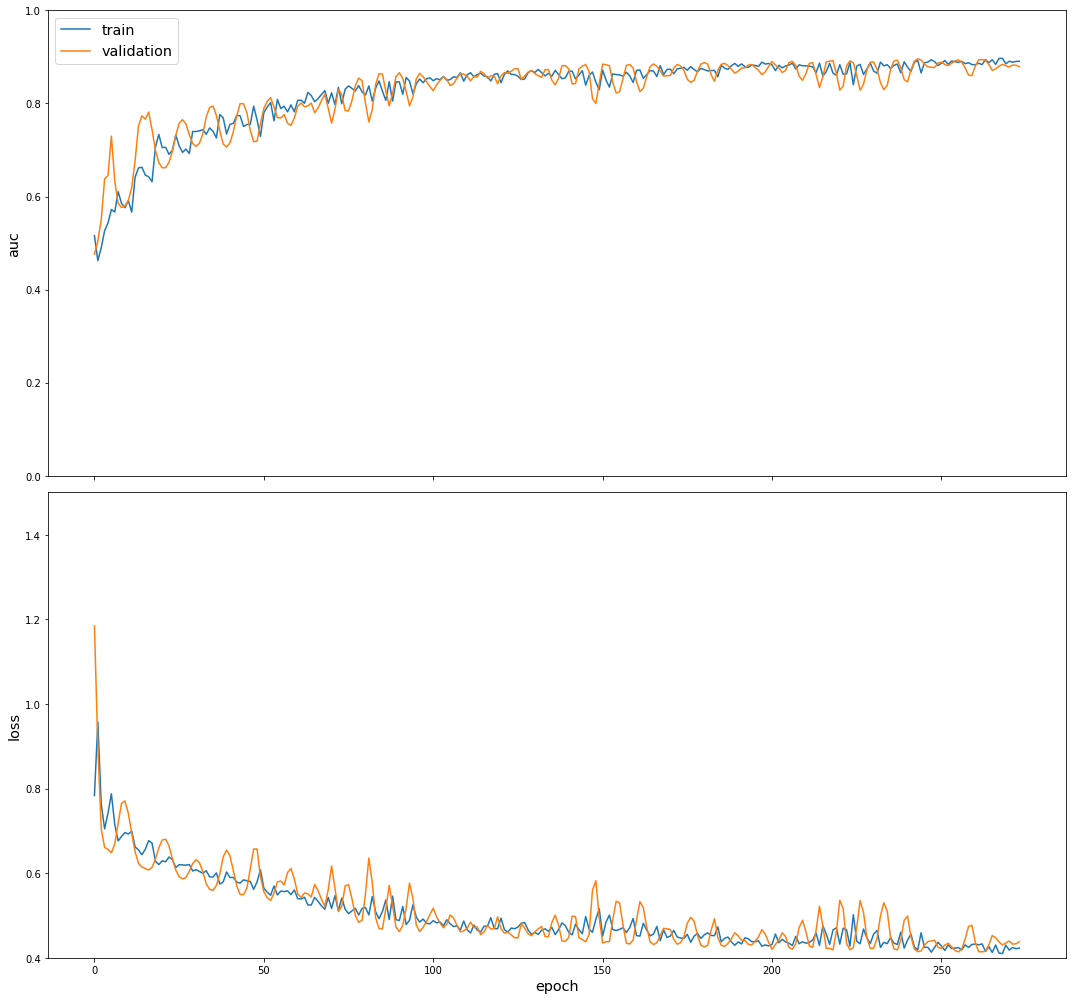

In [43]:
plot_history(history,individual_figsize=(15, 7))

In [ ]:
# model.load_weights("logs_retry/best_model.h5")

In [44]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [45]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 230ms/step - loss: 0.4315 - auc: 0.8834

Test Set Metrics:
	loss: 0.4315
	auc: 0.8834


In [46]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thres = roc_curve(test_targets[:,0],model.predict(test_gen)[0][:,0])
print (auc(fpr, tpr))

0.899586360502731


In [66]:
test_targets[:,0]

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 1., 0.

In [67]:
model.predict(test_gen)[0][:,0]

array([8.53149891e-01, 8.79134297e-01, 6.25324845e-01, 5.96068919e-01,
       1.28890395e-01, 1.33646396e-03, 6.03923023e-01, 5.88835143e-02,
       7.92641044e-02, 7.13550687e-01, 8.87566566e-01, 8.64614189e-01,
       8.63902569e-01, 3.07971954e-01, 9.06464577e-01, 5.86026371e-01,
       9.45584476e-01, 6.86825037e-01, 1.70581460e-01, 8.54505062e-01,
       1.07684419e-01, 7.99305320e-01, 8.47853906e-03, 5.44686437e-01,
       6.00559473e-01, 5.89605629e-01, 8.43812227e-01, 3.40326726e-02,
       8.67832184e-01, 3.67403105e-02, 8.80093336e-01, 9.11873996e-01,
       9.49992895e-01, 2.67682046e-01, 8.28569889e-01, 2.20120981e-01,
       7.62313306e-01, 4.70869709e-03, 5.95483065e-01, 5.52725613e-01,
       6.44038141e-01, 9.62389767e-01, 1.14721708e-01, 2.86397129e-01,
       3.56902108e-02, 2.20987111e-01, 8.23456228e-01, 8.80281389e-01,
       6.56311870e-01, 9.40575361e-01, 9.32577908e-01, 7.46508956e-01,
       8.14511478e-01, 8.09303045e-01, 8.83676171e-01, 8.63117337e-01,
      

In [68]:
GAT_Test = pd.DataFrame()
GAT_Test['Target'] = list(test_targets[:,0])
GAT_Test['GAT'] = model.predict(test_gen)[0][:,0]

In [70]:
GAT_Test.to_csv('GAT_Test.csv',index = False)

In [47]:
test_gen_real = generator.flow(test_subjects_real.index, test_targets_real)

In [48]:
result = pd.DataFrame(model.predict(test_gen_real)[0]).round(2)

In [52]:
result['ID'] = list(new_feature_A.ID)
result['Symbol'] = list(new_feature_A.Symbol)

In [54]:
result.sort_values(by=1,ascending = False)

,0,1,ID,Symbol
8501,0.00,1.00,145837,DRAIC
4818,0.00,1.00,280664,WFDC10B
901,0.00,1.00,4883,NPR3
6280,0.00,1.00,199800,ADM5
6276,0.00,1.00,414332,LCN10
...,...,...,...,...
8589,0.98,0.02,57343,ZNF304
3588,0.98,0.02,1183,CLCN4
458,0.98,0.02,51645,PPIL1
5281,0.99,0.01,5073,PARN


In [55]:
# result.sort_values(by=1,ascending = False).to_csv("PredictResult_213.csv",index = False)

In [58]:
new_feature[new_feature['Group']=='P'][['Symbol','ID']].to_csv('P_list_213.csv',index = False)

In [61]:
result

,0,1,ID,Symbol
0,0.83,0.17,220213,OTUD1
1,0.93,0.07,80775,TMEM177
2,0.84,0.16,5832,ALDH18A1
3,0.87,0.13,6732,SRPK1
4,0.91,0.09,94081,SFXN1
...,...,...,...,...
10853,0.02,0.98,117166,WFIKKN1
10854,0.34,0.66,91653,BOC
10855,0.60,0.40,7351,UCP2
10856,0.02,0.98,56142,PCDHA6


In [63]:
result[result[1]>0.9]

,0,1,ID,Symbol
53,0.00,1.00,79652,TMEM204
69,0.00,1.00,10186,LHFPL6
92,0.05,0.95,29995,LMCD1
106,0.06,0.94,25974,MMACHC
122,0.01,0.99,84981,MIR22HG
...,...,...,...,...
10844,0.02,0.98,56147,PCDHA1
10846,0.07,0.93,100506606,LOC100506606
10848,0.00,1.00,158046,NXNL2
10853,0.02,0.98,117166,WFIKKN1


array([[<AxesSubplot:title={'center':'1'}>]], dtype=object)

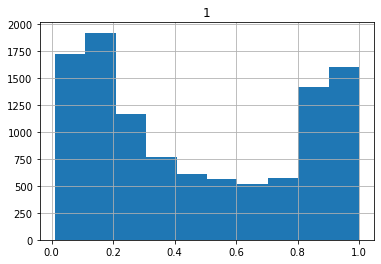

In [65]:
result.hist(column=1)